Plot saved to figures/repressilator_stochastic_plot.png


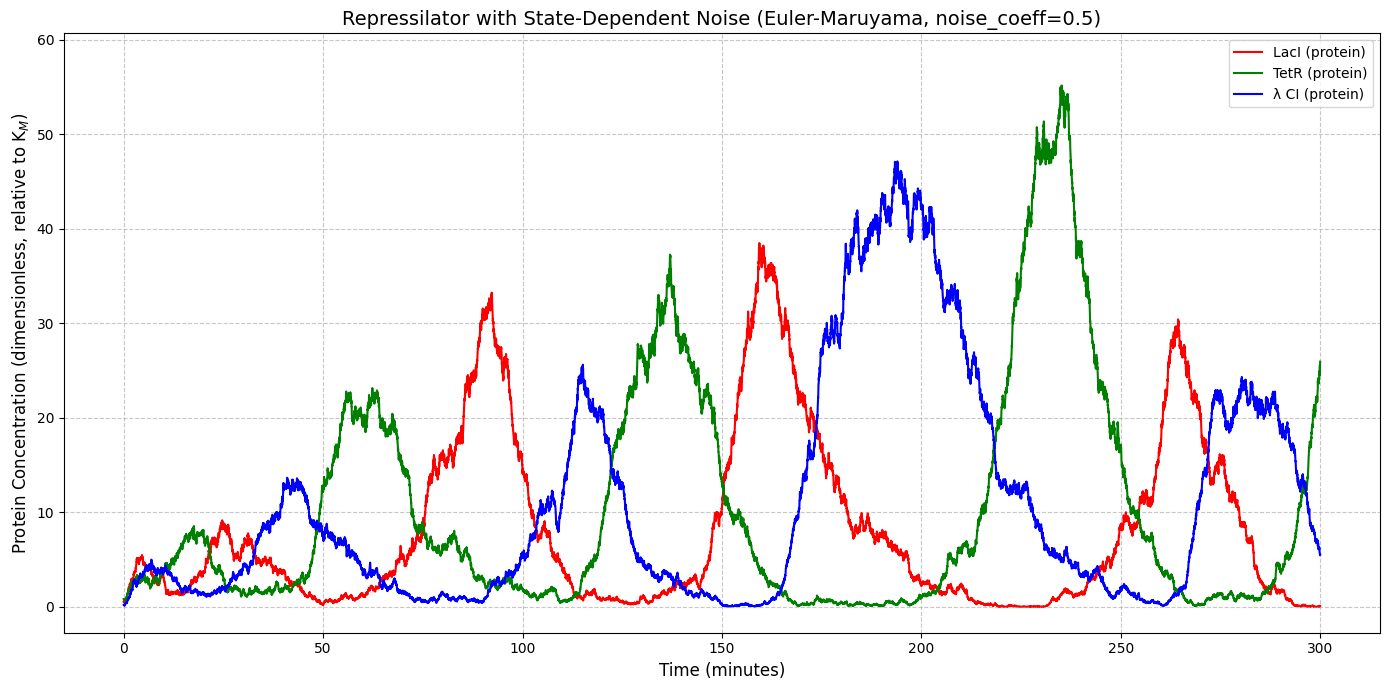


--- Stochastic Oscillation Analysis (LacI) ---
Mean Period: 79.89 ± 17.73 min (based on 3 cycles)
Mean Peak Amplitude: 27.82 ± 11.17
  (Note: Period and amplitude stats for stochastic data show variability)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os # Import the os module

# --- Parameters for the simulation ---
# These are based on Elowitz & Leibler (2000), Nature, Box 1 and Fig 1c context.
beta = 0.2      # Ratio of protein degradation rate to mRNA degradation rate
n = 2           # Hill coefficient (describes steepness/cooperativity of repression)
alpha = 50      # Dimensionless maximum transcription rate
alpha_0 = alpha * 0.001 # Dimensionless basal (leaky) transcription rate

# --- Noise parameter for the stochastic simulation ---
# This coefficient scales the strength of the state-dependent random fluctuations.
# Higher values mean more noise.
noise_coeff = 0.5

# --- Time settings for the simulation ---
t0_minutes, tf_minutes = 0, 300  # Total simulation time in minutes
# Time step for the Euler-Maruyama method (in dimensionless units)
dt_dimensionless = 0.01
# Array of dimensionless time points
t_dimensionless = np.arange(0, tf_minutes / 2, dt_dimensionless) # Divide by 2 for scaling

# --- Initial conditions ---
# [m1, p1, m2, p2, m3, p3] for LacI, TetR, CI respectively
# Dimensionless concentrations (protein conc. relative to K_M).
# Asymmetric conditions help initiate oscillations.
initial_conditions = np.array([0.1, 0.5, 0.2, 0.8, 0.3, 0.2])

# Initialize array to store simulation results
y_stochastic = np.zeros((6, len(t_dimensionless)))
y_stochastic[:, 0] = initial_conditions

# --- Euler-Maruyama loop for solving the Stochastic Differential Equations (SDEs) ---
# This loop calculates the state of the system at each time step,
# including deterministic changes and random fluctuations.
for i in range(1, len(t_dimensionless)):
    m1, p1, m2, p2, m3, p3 = y_stochastic[:, i-1]

    # Ensure protein concentrations are non-negative before taking sqrt for noise term
    p1_eff = max(0, p1)
    p2_eff = max(0, p2)
    p3_eff = max(0, p3)

    # Deterministic part (drift terms) - same as in the ODE model
    dm1_dt = -m1 + alpha / (1 + p3_eff**n) + alpha_0
    dp1_dt = -beta * (p1 - m1)
    dm2_dt = -m2 + alpha / (1 + p1_eff**n) + alpha_0
    dp2_dt = -beta * (p2 - m2)
    dm3_dt = -m3 + alpha / (1 + p2_eff**n) + alpha_0
    dp3_dt = -beta * (p3 - m3)

    # Stochastic part (diffusion terms) - representing random fluctuations
    # dW is an increment of a Wiener process (scaled Gaussian random number)
    dW1 = np.random.normal(0, 1) * np.sqrt(dt_dimensionless)
    dW2 = np.random.normal(0, 1) * np.sqrt(dt_dimensionless)
    dW3 = np.random.normal(0, 1) * np.sqrt(dt_dimensionless)

    # Update mRNA concentrations (deterministic)
    y_stochastic[0, i] = m1 + dm1_dt * dt_dimensionless
    y_stochastic[2, i] = m2 + dm2_dt * dt_dimensionless
    y_stochastic[4, i] = m3 + dm3_dt * dt_dimensionless

    # Update Protein concentrations (deterministic drift + stochastic diffusion)
    # Noise term is proportional to sqrt(protein_concentration)
    y_stochastic[1, i] = p1 + dp1_dt * dt_dimensionless + noise_coeff * np.sqrt(p1_eff) * dW1
    y_stochastic[3, i] = p2 + dp2_dt * dt_dimensionless + noise_coeff * np.sqrt(p2_eff) * dW2
    y_stochastic[5, i] = p3 + dp3_dt * dt_dimensionless + noise_coeff * np.sqrt(p3_eff) * dW3

    # Enforce non-negativity for protein concentrations after update
    y_stochastic[1, i] = max(0, y_stochastic[1, i])
    y_stochastic[3, i] = max(0, y_stochastic[3, i])
    y_stochastic[5, i] = max(0, y_stochastic[5, i])

# --- Convert dimensionless time to minutes for plotting ---
# Assuming 1 unit of dimensionless ODE time = 2 minutes (mRNA half-life)
time_minutes = t_dimensionless * 2

# --- Plotting the protein oscillations ---
plt.figure(figsize=(14,7))
plt.plot(time_minutes, y_stochastic[1], 'r-', label='LacI (protein)') # p1
plt.plot(time_minutes, y_stochastic[3], 'g-', label='TetR (protein)') # p2
plt.plot(time_minutes, y_stochastic[5], 'b-', label='λ CI (protein)') # p3

# --- Styling the plot ---
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Protein Concentration (dimensionless, relative to K$_M$)', fontsize=12)
plt.title(f'Repressilator with State-Dependent Noise (Euler-Maruyama, noise_coeff={noise_coeff})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# Adjust y-limit to ensure 0 is visible and there's a bit of padding
y_max_overall = max(y_stochastic[1].max(), y_stochastic[3].max(), y_stochastic[5].max())
plt.ylim(bottom=-y_max_overall * 0.05, top=y_max_overall * 1.1)
plt.tight_layout()

# --- ADD THIS SECTION TO SAVE THE FIGURE ---
FIGURES_DIR = 'figures'
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)

plot_filename = os.path.join(FIGURES_DIR, 'repressilator_stochastic_plot.png')
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
print(f"Plot saved to {plot_filename}")
# --- END OF SAVE FIGURE SECTION ---

plt.show() # Display the plot

# --- Basic Oscillation Analysis (can be less reliable for very noisy data) ---
# `find_peaks` helps identify the tops of the waves.
# Prominence and distance might need tuning based on noise_coeff.
# Calculate dt_minutes for distance conversion
dt_minutes_step = time_minutes[1] - time_minutes[0] if len(time_minutes) > 1 else (2 * dt_dimensionless)
min_peak_dist_samples = int(20 / dt_minutes_step) # Minimum peak distance ~20 minutes

peaks_lacI_indices, _ = find_peaks(y_stochastic[1], prominence=np.std(y_stochastic[1])/2 , distance=min_peak_dist_samples)

if len(peaks_lacI_indices) > 1:
    periods_lacI = np.diff(time_minutes[peaks_lacI_indices])
    mean_period_lacI = np.mean(periods_lacI)
    std_period_lacI = np.std(periods_lacI)
    print(f"\n--- Stochastic Oscillation Analysis (LacI) ---")
    print(f"Mean Period: {mean_period_lacI:.2f} ± {std_period_lacI:.2f} min (based on {len(periods_lacI)} cycles)")

    peak_amps_lacI = y_stochastic[1][peaks_lacI_indices]
    print(f"Mean Peak Amplitude: {np.mean(peak_amps_lacI):.2f} ± {np.std(peak_amps_lacI):.2f}")
    print(f"  (Note: Period and amplitude stats for stochastic data show variability)")
else:
    print("\nFewer than 2 peaks detected for LacI with current settings.")
    print("  Stochastic oscillations might be too irregular or noise_coeff too high/low for simple peak analysis.")
    print("  Consider adjusting 'prominence'/'distance' in find_peaks or the 'noise_coeff'.")